# Spectral pruning application to a simple regression problem

In order to understand the use of `Spectral` layer and the pruning procedure we can consider a simple regression problem

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from Spectral import Spectral, Pruning, update_train


As example we consider a very simple regression problem. First we generate a dataset of 2D points distributed according to
$$
y=x^\alpha + z
$$
where $z$ is Gaussian variable with 0 mean and $\sigma$ as variance

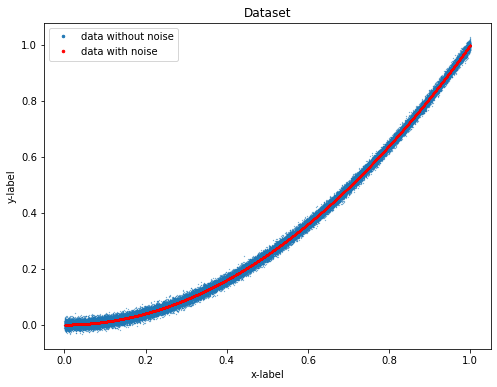

In [2]:
alpha = 2.
sigma = 0.01
size = 70000

x = np.linspace(0, 1, size)
z = np.random.normal(0, sigma, size)  # noise
t = x**alpha
y = t + z   # add noise

X = []
Y = []
for i in range(size):
    X.append([x[i]])
    Y.append([y[i]])

X = np.array(X)
Y = np.array(Y)

plt.figure (figsize = (8, 6))
plt.plot(X, Y, marker='.', linestyle = '', label='data without noise', markersize=0.5)
plt.plot(x, t, marker='.', linestyle='', color='red', label='data with noise', markersize=0.5)
plt.title('Dataset')
plt.legend(markerscale=10.)
plt.xlabel('x-label')
plt.ylabel('y-label')
plt.show()

Let's create validation and test dataset using `PyTorch` base classes

In [3]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

X = torch.from_numpy(X)
Y = torch.from_numpy(Y)

# Define dataset
dataset = TensorDataset(X, Y)
train_ds, val_ds, test_ds = random_split(dataset, [50000, 10000, 10000])

# Define data loader
batch_size = 1500
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size)
test_dl = DataLoader(test_ds, batch_size)

## Define Spectral model
As pretraining we consider a big model in order to apply the pruning procedure to it. The optimal configuration for the pretraining of the model is to allow training only on eigenvalue, while eigenvectors are fixed.

In [4]:
# Spectral Regression model with only train of eigenvalues
config = {'base_grad' : False,
         'start_grad' : True,
         'end_grad' : True,
         'bias': False,
          'dtype': float}

class SpectralRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.spectralin = Spectral(1, 50, **config)
        self.spectral1 = Spectral(50, 50, **config)
        self.spectralout = Spectral(50, 1, **config)

    def forward(self,x):
        out = self.spectralin(x)  # Input: first linear transformation
        out = self.spectral1(out) # Linear transformation
        out = F.elu(out)   # Non linear filter
        out = self.spectralout(out)  # Last linear transformation: output
        return out

    def training_step(self, batch):
        x, y = batch
        out = self(x)                  # Generate predictions
        loss = F.mse_loss(out, y) # Calculate loss
        return loss

    def validation_step(self, batch):
        x, y= batch
        out = self(x)                    # Generate predictions
        loss = F.mse_loss(out, y)   # Calculate loss
        return {'val_loss': loss}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.6f}".format(epoch, result['val_loss']))


spectral_model = SpectralRegression()

In [5]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results
    #es = EarlyStopping(patience=10)

    for epoch in range(epochs):

        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

        # Early stopping
        #if es.step(loss):
        #        break

    return history

Let's train the model for 20 epochs.

In [6]:
args = {'lr': 0.03,
       'model': spectral_model,
       'train_loader': train_dl,
       'val_loader': val_dl,
       'opt_func': torch.optim.Adam}

history_spectral1 = fit(20, **args)



Epoch [0], val_loss: 0.015782
Epoch [1], val_loss: 0.012809
Epoch [2], val_loss: 0.012597
Epoch [3], val_loss: 0.012571
Epoch [4], val_loss: 0.012548
Epoch [5], val_loss: 0.012518
Epoch [6], val_loss: 0.012531
Epoch [7], val_loss: 0.012498
Epoch [8], val_loss: 0.012440
Epoch [9], val_loss: 0.012356
Epoch [10], val_loss: 0.012031
Epoch [11], val_loss: 0.007111
Epoch [12], val_loss: 0.000275
Epoch [13], val_loss: 0.000144
Epoch [14], val_loss: 0.000143
Epoch [15], val_loss: 0.000157
Epoch [16], val_loss: 0.000142
Epoch [17], val_loss: 0.000152
Epoch [18], val_loss: 0.000157
Epoch [19], val_loss: 0.000144


Now we can apply the Pruning procedure and allow training on eigenvalue too

In [7]:
# Prune the model
Pruning(spectral_model, 80, input_fixed=True)

# Allow training just on eigenvalues
update_train(spectral_model, base=True, diag_start=True, diag_end=True)

New pruned model:
SpectralRegression(
  (spectralin): Spectral(in_dim=1, out_dim=3, base_grad=False, start_grad=True, end_grad=True, bias=False)
  (spectral1): Spectral(in_dim=3, out_dim=17, base_grad=False, start_grad=True, end_grad=True, bias=False)
  (spectralout): Spectral(in_dim=17, out_dim=1, base_grad=False, start_grad=True, end_grad=True, bias=False)
)
Modified model: 
SpectralRegression(
  (spectralin): Spectral(in_dim=1, out_dim=3, base_grad=True, start_grad=True, end_grad=True, bias=False)
  (spectral1): Spectral(in_dim=3, out_dim=17, base_grad=True, start_grad=True, end_grad=True, bias=False)
  (spectralout): Spectral(in_dim=17, out_dim=1, base_grad=True, start_grad=True, end_grad=True, bias=False)
)


/usr/lib/python3/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


At this point we can train the pruned model.

In [8]:
args = {'lr': 0.03,
       'model': spectral_model,
       'train_loader': train_dl,
       'val_loader': val_dl,
       'opt_func': torch.optim.Adam}

history_spectral2 = fit(20, **args)

Epoch [0], val_loss: 0.028093
Epoch [1], val_loss: 0.004437
Epoch [2], val_loss: 0.000927
Epoch [3], val_loss: 0.000173
Epoch [4], val_loss: 0.000160
Epoch [5], val_loss: 0.000160
Epoch [6], val_loss: 0.000162
Epoch [7], val_loss: 0.000159
Epoch [8], val_loss: 0.000163
Epoch [9], val_loss: 0.000159
Epoch [10], val_loss: 0.000162
Epoch [11], val_loss: 0.000161
Epoch [12], val_loss: 0.000161
Epoch [13], val_loss: 0.000159
Epoch [14], val_loss: 0.000161
Epoch [15], val_loss: 0.000159
Epoch [16], val_loss: 0.000159
Epoch [17], val_loss: 0.000158
Epoch [18], val_loss: 0.000160
Epoch [19], val_loss: 0.000167


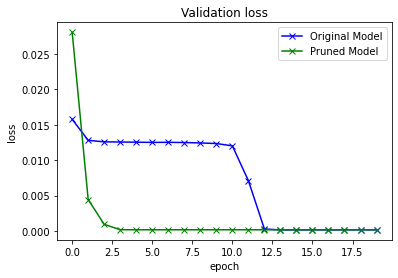

In [9]:
losses_spectral1 = [result['val_loss'] for result in history_spectral1]
losses_spectral2 = [result['val_loss'] for result in history_spectral2]

plt.plot(losses_spectral1, '-x', color='blue', label='Original Model')
plt.plot(losses_spectral2, '-x', color='green', label='Pruned Model' )
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Validation loss')
plt.legend()
plt.show()